### Pandas를 활용한 서울시 CCTV현황 분석 및 인구 현황 분석

In [3]:
import pandas as pd
import numpy as np
# import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import json
import folium
warnings.filterwarnings("ignore")


In [2]:
# 한글 폰트 문제 해결 
# matplotlib은 한글 폰트를 지원하지 않음
# os정보
import platform

# font_manager : 폰트 관리 모듈
# rc : 폰트 변경 모듈
from matplotlib import font_manager, rc
# unicode 설정
plt.rcParams['axes.unicode_minus'] = False

if platform.system() == 'Darwin':
    rc('font', family='AppleGothic') # os가 macos
elif platform.system() == 'Windows':
    path = 'c:/Windows/Fonts/malgun.ttf' # os가 windows
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print("Unknown System")

### CCTV 설치 현황

In [18]:
CCTV_Seoul = pd.read_excel('../Data/CCTV_in_Seoul_2018.xlsx')
CCTV_Seoul.head()

,기관명,소계,2011년 이전,2012년,2013년,2014년,2015년,2016년,2017년,2018년
0,강남구,5221,1944.0,195.0,316.0,430,546,765,577,448
1,강동구,1879,303.0,387.0,134.0,59,144,194,273,385
2,강북구,1265,243.0,88.0,141.0,74,145,254,1,319
3,강서구,1617,219.0,155.0,118.0,230,187,190,264,254
4,관악구,3985,430.0,56.0,419.0,487,609,619,694,671


In [5]:
CCTV_Seoul.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   기관명       25 non-null     object 
 1   소계        25 non-null     int64  
 2   2011년 이전  23 non-null     float64
 3   2012년     23 non-null     float64
 4   2013년     23 non-null     float64
 5   2014년     25 non-null     int64  
 6   2015년     25 non-null     int64  
 7   2016년     25 non-null     int64  
 8   2017년     25 non-null     int64  
 9   2018년     25 non-null     int64  
dtypes: float64(3), int64(6), object(1)
memory usage: 2.1+ KB


In [19]:
# 기관명을 구별로 변경하기
CCTV_Seoul.rename(columns = {'기관명':'구별'},inplace=True)
CCTV_Seoul.head()

,구별,소계,2011년 이전,2012년,2013년,2014년,2015년,2016년,2017년,2018년
0,강남구,5221,1944.0,195.0,316.0,430,546,765,577,448
1,강동구,1879,303.0,387.0,134.0,59,144,194,273,385
2,강북구,1265,243.0,88.0,141.0,74,145,254,1,319
3,강서구,1617,219.0,155.0,118.0,230,187,190,264,254
4,관악구,3985,430.0,56.0,419.0,487,609,619,694,671


In [11]:
# NaN 데이터 확인 후 Nan이 있으면 NaN을 처리하기
CCTV_Seoul.isnull().any()

구별          False
소계          False
2011년 이전     True
2012년        True
2013년        True
2014년       False
2015년       False
2016년       False
2017년       False
2018년       False
dtype: bool

In [12]:
CCTV_Seoul.describe()

,소계,2011년 이전,2012년,2013년,2014년,2015년,2016년,2017년,2018년
count,25.000000,23.000000,23.000000,23.000000,25.000000,25.000000,25.000000,25.000000,25.000000
mean,2219.720000,580.478261,123.826087,194.217391,249.920000,226.880000,267.360000,299.440000,349.480000
std,967.646523,488.248248,81.895528,135.556414,285.271935,144.643908,160.365956,216.219618,218.601067
min,858.000000,8.000000,7.000000,8.000000,21.000000,59.000000,21.000000,1.000000,9.000000
25%,1586.000000,228.500000,83.500000,106.500000,87.000000,130.000000,155.000000,136.000000,195.000000
50%,1935.000000,481.000000,108.000000,185.000000,134.000000,180.000000,254.000000,273.000000,328.000000
75%,2775.000000,775.500000,158.000000,235.000000,241.000000,268.000000,326.000000,372.000000,448.000000
max,5221.000000,1944.000000,387.000000,599.000000,1326.000000,609.000000,765.000000,933.000000,830.000000


In [20]:
CCTV_Seoul[['구별','2011년 이전','2012년','2013년']]
# NaN은 CCTV가 없다는 ... 내용인듯 ? min이 10개도 안되는 지역이 있고 없는 지역만 계쏙 없음
# 동대문구와 중랑구가 없음 
for i in range(2, len(CCTV_Seoul.columns)):
    nanCount = len(CCTV_Seoul.iloc[:,i] [CCTV_Seoul.iloc[:,i].isnull()])
    print(CCTV_Seoul.columns[i],":%5d"%(nanCount))

2011년 이전 :    2
2012년 :    2
2013년 :    2
2014년 :    0
2015년 :    0
2016년 :    0
2017년 :    0
2018년 :    0


In [23]:
# NaN을 9으로 변환하기
CCTV_Seoul = CCTV_Seoul.fillna(0)

In [24]:
for i in range(2, len(CCTV_Seoul.columns)):
    nanCount = len(CCTV_Seoul.iloc[:,i] [CCTV_Seoul.iloc[:,i].isnull()])
    print(CCTV_Seoul.columns[i],":%5d"%(nanCount))

2011년 이전 :    0
2012년 :    0
2013년 :    0
2014년 :    0
2015년 :    0
2016년 :    0
2017년 :    0
2018년 :    0


---
### 인구현황

In [30]:
pop_Seoul = pd.read_excel('../Data/population_in_Seoul_2020.xlsx',
                          header=3, # Excel에서 3번째 꺼
                          usecols="B,D,G,J,N"
                        )
pop_Seoul.head()

,자치구,계,계.1,계.2,65세이상고령자
0,합계,10013781,9733655,280126,1518239
1,종로구,161984,151217,10767,28073
2,중구,136469,126175,10294,23794
3,용산구,246165,229579,16586,39439
4,성동구,307193,299042,8151,44728


In [32]:
# 열 이름 변경
pop_Seoul.columns = ['구별','인구수','한국인','외국인','고령자']
# index0 합계행 삭제
pop_Seoul.drop([0],inplace=True)
pop_Seoul.head()

,구별,인구수,한국인,외국인,고령자
1,종로구,161984,151217,10767,28073
2,중구,136469,126175,10294,23794
3,용산구,246165,229579,16586,39439
4,성동구,307193,299042,8151,44728
5,광진구,365990,350417,15573,48989


In [34]:
pop_Seoul.tail()

,구별,인구수,한국인,외국인,고령자
21,관악구,516662,499374,17288,76664
22,서초구,434801,430568,4233,58332
23,강남구,549898,544804,5094,72602
24,송파구,680883,674095,6788,89539
25,강동구,457042,452646,4396,66401


---
### CCTV 현황

In [35]:
CCTV_Seoul.head()

,구별,소계,2011년 이전,2012년,2013년,2014년,2015년,2016년,2017년,2018년
0,강남구,5221,1944.0,195.0,316.0,430,546,765,577,448
1,강동구,1879,303.0,387.0,134.0,59,144,194,273,385
2,강북구,1265,243.0,88.0,141.0,74,145,254,1,319
3,강서구,1617,219.0,155.0,118.0,230,187,190,264,254
4,관악구,3985,430.0,56.0,419.0,487,609,619,694,671


In [39]:
# CCTV가 어디가 제일 많어?
CCTV_Seoul.sort_values(by='소계', ascending=False).head()

,구별,소계,2011년 이전,2012년,2013년,2014년,2015년,2016년,2017년,2018년
0,강남구,5221,1944.0,195.0,316.0,430,546,765,577,448
4,관악구,3985,430.0,56.0,419.0,487,609,619,694,671
6,구로구,3227,852.0,219.0,349.0,187,268,326,540,486
16,성북구,3003,779.0,84.0,304.0,241,279,388,285,643
21,은평구,2962,1365.0,83.0,99.0,343,180,296,229,367


#### 3년간 CCTV증가율을 구해서 CCTV가 제일 많이 증가한 구를 표시 (16~)


In [42]:
CCTV_Seoul['최근증가율'] = \
    ( CCTV_Seoul.iloc[:,7:10].sum(axis=1)) / (CCTV_Seoul.iloc[:,2:7].sum(axis=1) ) * 100
CCTV_Seoul.sort_values(by='최근증가율', ascending=False).head()

,구별,소계,2011년 이전,2012년,2013년,2014년,2015년,2016년,2017년,2018년,최근증가율
23,중구,1544,25.0,165.0,114.0,80,245,270,317,328,145.468998
19,영등포구,2495,132.0,121.0,206.0,217,366,289,371,793,139.443378
15,성동구,2679,665.0,109.0,118.0,101,258,201,933,294,114.148681
7,금천구,1634,27.0,17.0,242.0,101,382,136,199,530,112.483745
5,광진구,1581,470.0,42.0,83.0,87,64,21,468,346,111.930295


---
### 인구현황

In [44]:
pop_Seoul.head()

,구별,인구수,한국인,외국인,고령자
1,종로구,161984,151217,10767,28073
2,중구,136469,126175,10294,23794
3,용산구,246165,229579,16586,39439
4,성동구,307193,299042,8151,44728
5,광진구,365990,350417,15573,48989


In [49]:
# 구별 항목 파악
print(pop_Seoul['구별'].unique())
print(len(pop_Seoul['구별'].unique()))

['종로구' '중구' '용산구' '성동구' '광진구' '동대문구' '중랑구' '성북구' '강북구' '도봉구' '노원구' '은평구'
 '서대문구' '마포구' '양천구' '강서구' '구로구' '금천구' '영등포구' '동작구' '관악구' '서초구' '강남구' '송파구'
 '강동구']
25


In [67]:
# 고령자 비율과 외국인 비율을 계산후 적용
pop_Seoul['외국인비율'] = pop_Seoul['외국인'] / pop_Seoul['인구수'] * 100
pop_Seoul['고령자비율'] = pop_Seoul['고령자'] / pop_Seoul['인구수'] * 100

In [78]:
# 인구수가 제일 많은 지역
pop_Seoul.sort_values(by='인구수', ascending=False).head(2)

,구별,인구수,한국인,외국인,고령자,외국인비율,고령자비율
24,송파구,680883,674095,6788,89539,0.996941,13.150424
16,강서구,595703,589302,6401,85992,1.074529,14.435381


In [79]:
# 외국인수가 제일 많은 지역
pop_Seoul.sort_values(by='외국인', ascending=False).head(2)

,구별,인구수,한국인,외국인,고령자,외국인비율,고령자비율
19,영등포구,404766,371903,32863,59373,8.119012,14.668475
17,구로구,438308,405837,32471,67432,7.408261,15.384615


In [80]:
# 외국인 비율이 제일 많은 지역 
pop_Seoul.sort_values(by='외국인비율', ascending=False).head(2)

,구별,인구수,한국인,외국인,고령자,외국인비율,고령자비율
19,영등포구,404766,371903,32863,59373,8.119012,14.668475
2,중구,136469,126175,10294,23794,7.543105,17.435462


In [82]:
# 고령자가 제일 많은 지역
pop_Seoul.sort_values(by='고령자', ascending=False).head(2)

,구별,인구수,한국인,외국인,고령자,외국인비율,고령자비율
24,송파구,680883,674095,6788,89539,0.996941,13.150424
16,강서구,595703,589302,6401,85992,1.074529,14.435381


In [85]:
#고령자 비율이 제일 높은 지역
pop_Seoul.sort_values(by='고령자비율', ascending=False).head(5)

,구별,인구수,한국인,외국인,고령자,외국인비율,고령자비율
9,강북구,316750,312985,3765,61660,1.188635,19.466456
10,도봉구,333495,331238,2257,60023,0.676772,17.998171
2,중구,136469,126175,10294,23794,7.543105,17.435462
1,종로구,161984,151217,10767,28073,6.646953,17.330724
12,은평구,482509,478019,4490,82245,0.930553,17.045278


In [81]:
#고령자 비율이 제일 적은 지역
pop_Seoul.sort_values(by='고령자비율', ascending=True).head(2)

,구별,인구수,한국인,외국인,고령자,외국인비율,고령자비율
24,송파구,680883,674095,6788,89539,0.996941,13.150424
23,강남구,549898,544804,5094,72602,0.926354,13.202812


---
### CCTV Data와 인구현황 Data 합치기

In [122]:
data_result = pd.merge(CCTV_Seoul,pop_Seoul, on='구별')
data_result.head()

,구별,소계,2011년 이전,2012년,2013년,2014년,2015년,2016년,2017년,2018년,최근증가율,인구수,한국인,외국인,고령자,외국인비율,고령자비율
0,강남구,5221,1944.0,195.0,316.0,430,546,765,577,448,52.171379,549898,544804,5094,72602,0.926354,13.202812
1,강동구,1879,303.0,387.0,134.0,59,144,194,273,385,82.960078,457042,452646,4396,66401,0.961837,14.528424
2,강북구,1265,243.0,88.0,141.0,74,145,254,1,319,83.068017,316750,312985,3765,61660,1.188635,19.466456
3,강서구,1617,219.0,155.0,118.0,230,187,190,264,254,77.887789,595703,589302,6401,85992,1.074529,14.435381
4,관악구,3985,430.0,56.0,419.0,487,609,619,694,671,99.150425,516662,499374,17288,76664,3.346095,14.838328


In [123]:
data_result.drop(data_result.iloc[:,2:10], axis=1,inplace=True)
data_result

,구별,소계,최근증가율,인구수,한국인,외국인,고령자,외국인비율,고령자비율
0,강남구,5221,52.171379,549898,544804,5094,72602,0.926354,13.202812
1,강동구,1879,82.960078,457042,452646,4396,66401,0.961837,14.528424
2,강북구,1265,83.068017,316750,312985,3765,61660,1.188635,19.466456
3,강서구,1617,77.887789,595703,589302,6401,85992,1.074529,14.435381
4,관악구,3985,99.150425,516662,499374,17288,76664,3.346095,14.838328
5,광진구,1581,111.930295,365990,350417,15573,48989,4.255034,13.385338
6,구로구,3227,72.106667,438308,405837,32471,67432,7.408261,15.384615
7,금천구,1634,112.483745,251370,232583,18787,38508,7.473843,15.319251
8,노원구,1906,42.026826,535495,531037,4458,82682,0.832501,15.440294
9,도봉구,858,66.601942,333495,331238,2257,60023,0.676772,17.998171


In [ ]:
# 강사님이 보여주신 다른 방법
# for i in data_result.columns[2:10]:
#     del data_result[i]

In [124]:
data_result.set_index('구별',inplace=True)

,소계,최근증가율,인구수,한국인,외국인,고령자,외국인비율,고령자비율
구별,,,,,,,,
강남구,5221,52.171379,549898,544804,5094,72602,0.926354,13.202812
강동구,1879,82.960078,457042,452646,4396,66401,0.961837,14.528424
강북구,1265,83.068017,316750,312985,3765,61660,1.188635,19.466456
강서구,1617,77.887789,595703,589302,6401,85992,1.074529,14.435381
관악구,3985,99.150425,516662,499374,17288,76664,3.346095,14.838328


In [127]:
data_result.head()

,소계,최근증가율,인구수,한국인,외국인,고령자,외국인비율,고령자비율
구별,,,,,,,,
강남구,5221,52.171379,549898,544804,5094,72602,0.926354,13.202812
강동구,1879,82.960078,457042,452646,4396,66401,0.961837,14.528424
강북구,1265,83.068017,316750,312985,3765,61660,1.188635,19.466456
강서구,1617,77.887789,595703,589302,6401,85992,1.074529,14.435381
관악구,3985,99.150425,516662,499374,17288,76664,3.346095,14.838328


In [111]:
# 고령자 비율과 소계의 상관계수
np.corrcoef(data_result['고령자비율'],data_result['소계'])
# 고령자가 많을수록 CCTV가 적어지는 편이다 ?? 과연 맞는 말인가?

array([[ 1.        , -0.44225083],
       [-0.44225083,  1.        ]])

In [112]:
#외국인으로 봐보자
np.corrcoef(data_result['외국인'],data_result['소계'])
# 딱히 상관은 없는거같다

array([[1.        , 0.17444235],
       [0.17444235, 1.        ]])

In [125]:
#그럼 한국인은?
np.corrcoef(data_result['한국인'],data_result['소계'])

array([[1.        , 0.36453609],
       [0.36453609, 1.        ]])

In [126]:
# 딱히 인구수도 그다지 상관없는거 같고 ?
np.corrcoef(data_result['인구수'],data_result['소계'])

array([[1.        , 0.38064812],
       [0.38064812, 1.        ]])

In [135]:
data_result.sort_values(by='소계')['소계']

구별
도봉구      858
중랑구     1068
강북구     1265
종로구     1471
중구      1544
광진구     1581
송파구     1586
강서구     1617
금천구     1634
동작구     1780
강동구     1879
노원구     1906
마포구     1935
동대문구    2003
용산구     2063
서대문구    2121
영등포구    2495
성동구     2679
양천구     2775
서초구     2835
은평구     2962
성북구     3003
구로구     3227
관악구     3985
강남구     5221
Name: 소계, dtype: int64

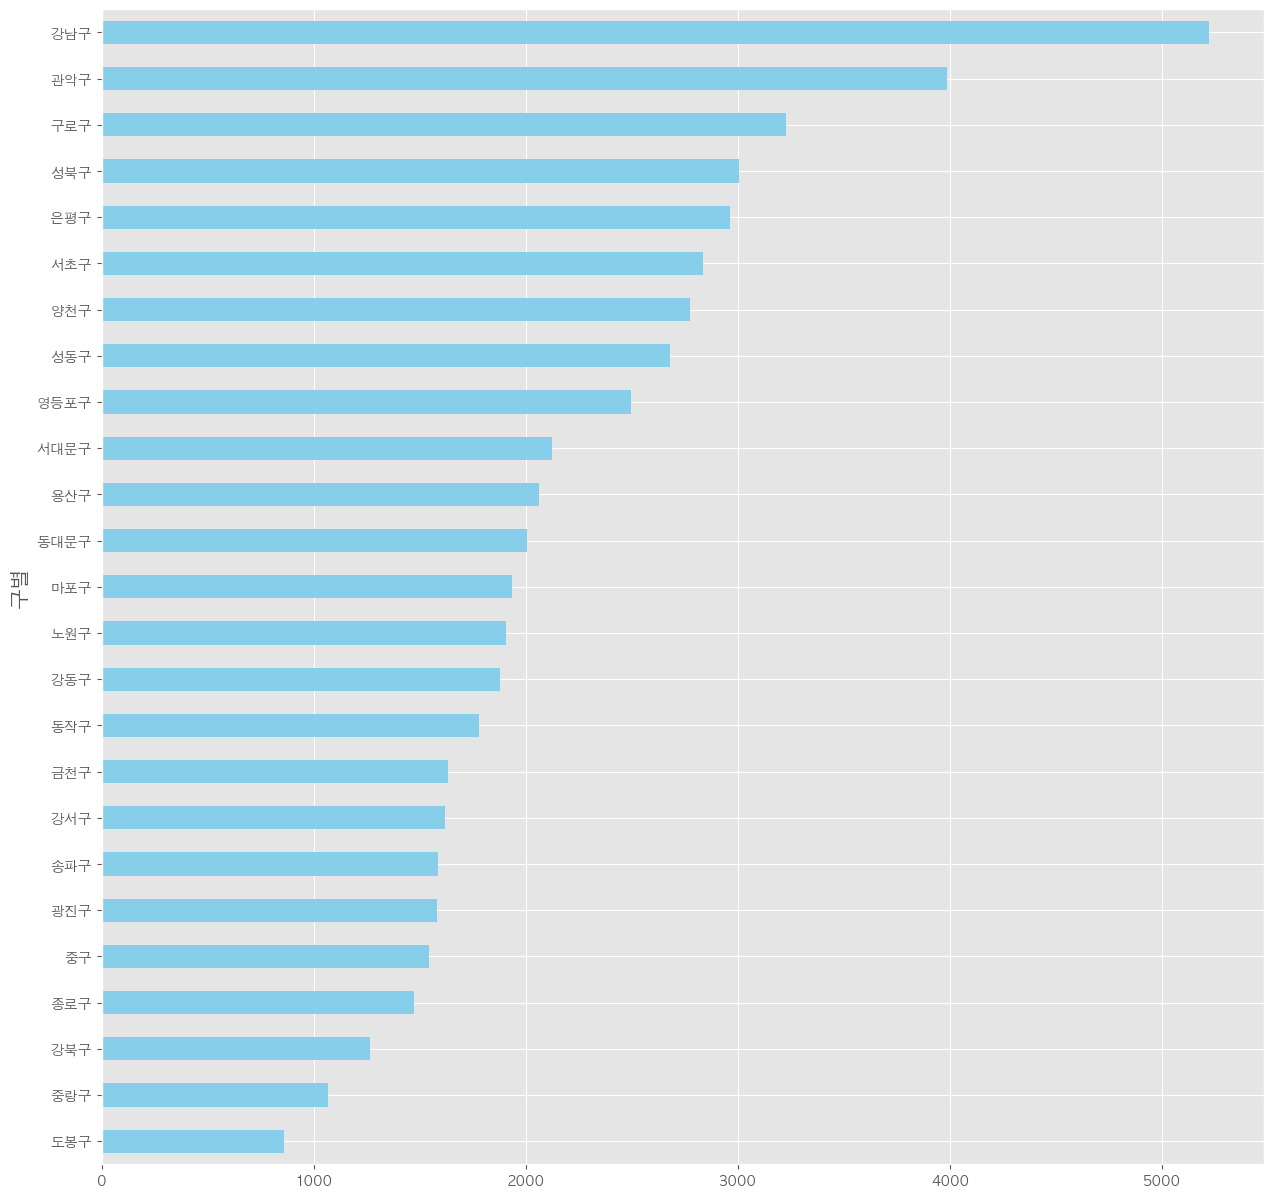

In [144]:
plt.style.use('ggplot')
data_result.sort_values(by='소계')['소계'].plot(
# data_result['소계'].sort_values(by='소계').plot(
    kind='barh', 
    figsize=(15,15),
    color = 'skyblue',
    )
plt.xticks(rotation="horizontal",size=10) # vertical은 90도
plt.ylabel("구별", size=15)
plt.show()

In [149]:
data_result.head()

,소계,최근증가율,인구수,한국인,외국인,고령자,외국인비율,고령자비율
구별,,,,,,,,
강남구,5221,52.171379,549898,544804,5094,72602,0.926354,13.202812
강동구,1879,82.960078,457042,452646,4396,66401,0.961837,14.528424
강북구,1265,83.068017,316750,312985,3765,61660,1.188635,19.466456
강서구,1617,77.887789,595703,589302,6401,85992,1.074529,14.435381
관악구,3985,99.150425,516662,499374,17288,76664,3.346095,14.838328


In [159]:
data_result['CCTV비율']=data_result['소계'] / data_result['인구수'] *100
data_result

,소계,최근증가율,인구수,한국인,외국인,고령자,외국인비율,고령자비율,CCTV비율
구별,,,,,,,,,
강남구,5221,52.171379,549898,544804,5094,72602,0.926354,13.202812,0.949449
강동구,1879,82.960078,457042,452646,4396,66401,0.961837,14.528424,0.411122
강북구,1265,83.068017,316750,312985,3765,61660,1.188635,19.466456,0.399369
강서구,1617,77.887789,595703,589302,6401,85992,1.074529,14.435381,0.271444
관악구,3985,99.150425,516662,499374,17288,76664,3.346095,14.838328,0.771297
광진구,1581,111.930295,365990,350417,15573,48989,4.255034,13.385338,0.431979
구로구,3227,72.106667,438308,405837,32471,67432,7.408261,15.384615,0.736240
금천구,1634,112.483745,251370,232583,18787,38508,7.473843,15.319251,0.650038
노원구,1906,42.026826,535495,531037,4458,82682,0.832501,15.440294,0.355932


In [155]:
# 인구대비 CCTV 비율 
pop_cctv = pd.DataFrame(data_result['소계'] / data_result['인구수'] *100).sort_values(by=0, ascending=True)
pop_cctv

,0
구별,
송파구,0.232933
도봉구,0.257275
중랑구,0.266548
강서구,0.271444
노원구,0.355932
강북구,0.399369
강동구,0.411122
광진구,0.431979
동작구,0.436486


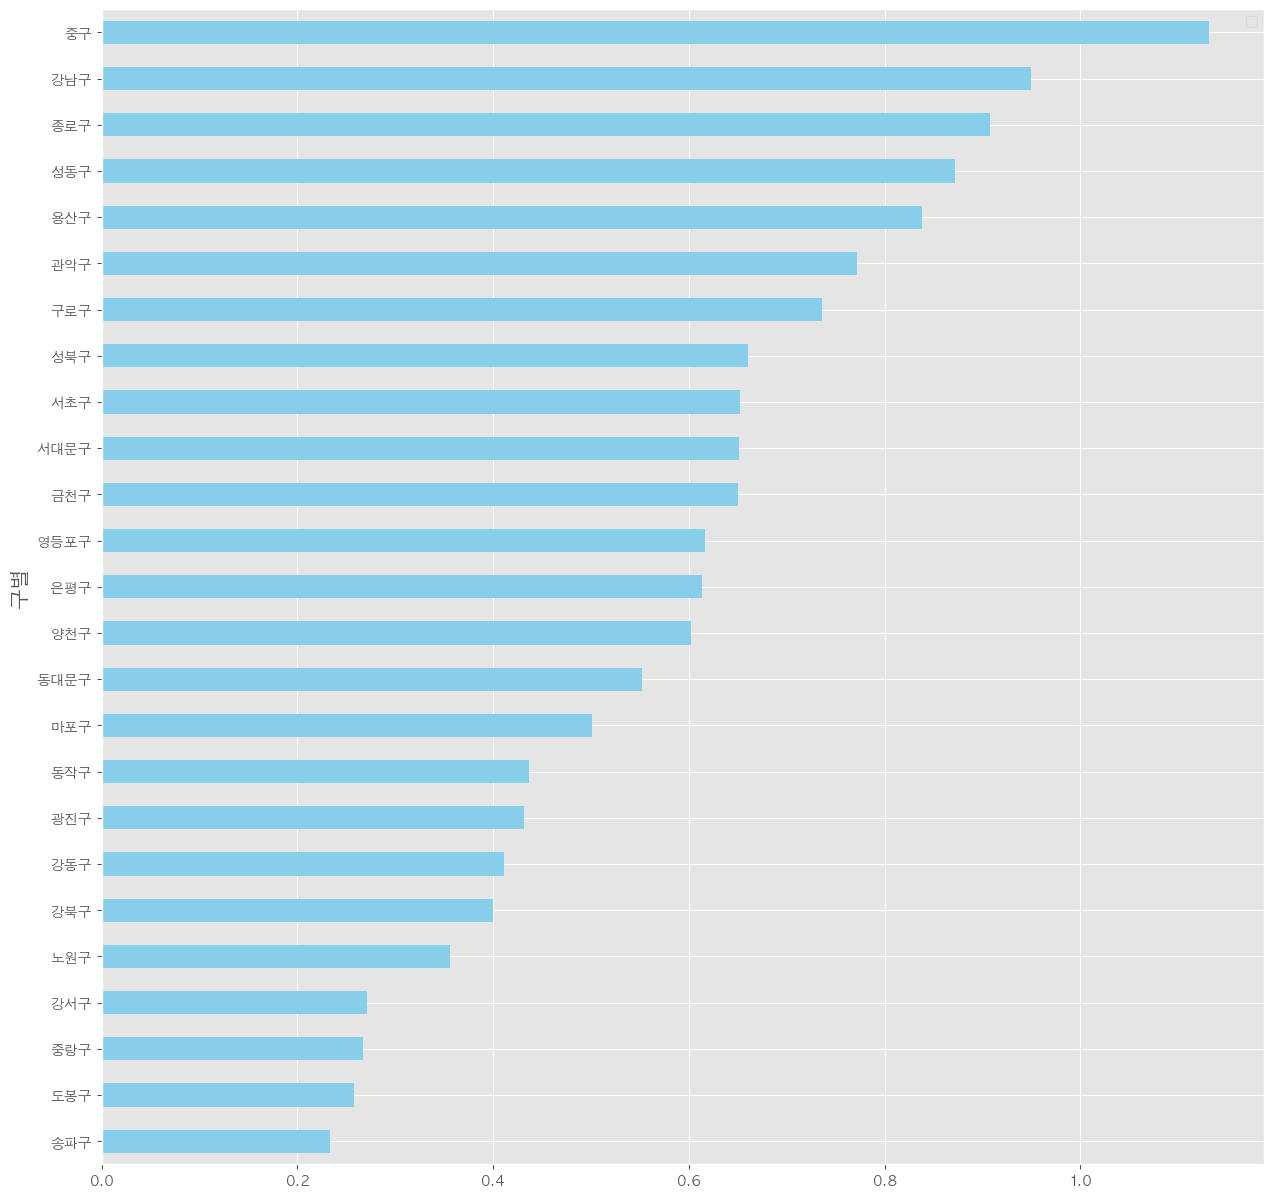

In [162]:
plt.style.use('ggplot')
data_result['CCTV비율'].sort_values().plot(
    kind='barh', 
    figsize=(15,15),
    color = 'skyblue',
    )
plt.xticks(rotation="horizontal",size=10) # vertical은 90도
plt.ylabel("구별", size=15)
plt.legend('')
plt.show()

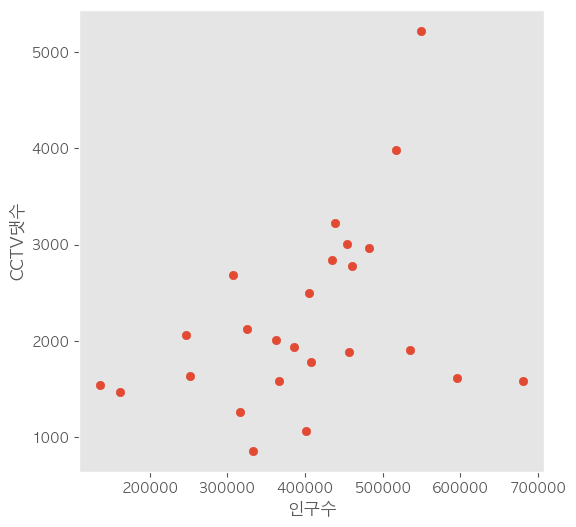

In [163]:
# 산점도를 이용한 시각화
plt.figure(figsize=(6,6))
plt.scatter(data_result['인구수'], data_result['소계'])
plt.xlabel('인구수')
plt.ylabel('CCTV댓수')
plt.grid()
plt.show()

In [164]:
# 인구수, 소계에 따른 기준선 만들기
fp1 = np.polyfit(data_result['인구수'], data_result['소계'],1)
fp1

array([2.88522756e-03, 1.06403852e+03])

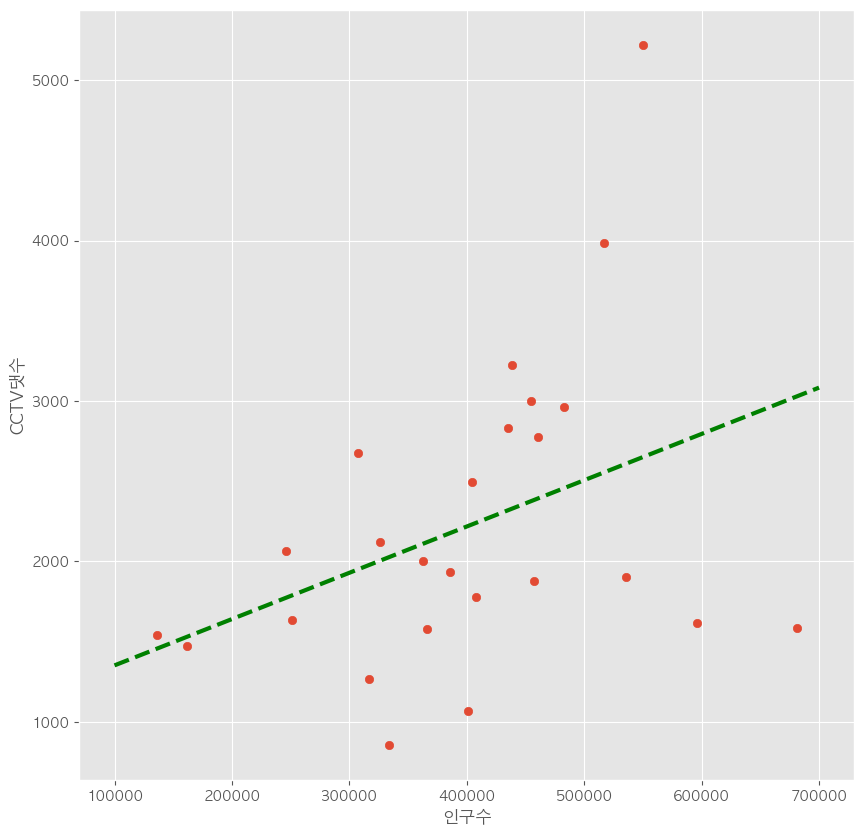

In [169]:
# y축 데이터
f1 = np.poly1d(fp1)

# x축 데이터
fx = np.linspace(100000,700000)

# 산점도를 이용한 시각화
plt.figure(figsize=(10,10))
plt.scatter(data_result['인구수'], data_result['소계'])
plt.plot(fx, f1(fx), ls='dashed',lw=3,color='g')
plt.xlabel('인구수')
plt.ylabel('CCTV댓수')
# plt.grid()
plt.show()

이 선 기준으로 가까울 수록 cctv가 적당하다, 위에 있을수록 많다

---
### 직선과의 오차를 구하는 공식과 오차가 큰 순으로 데이터를 정렬 후 그래프 그리기

In [166]:
# 기준선 구하기
fp1 = np.polyfit(data_result['인구수'], data_result['소계'],1)

# y축 ; CCTV 기준치 구하기
f1 = np.poly1d(fp1)

# x축 데이터 (인구수)
fx = np.linspace(100000,700000)

#소계에서 기준인구수 차이로 오차값 구하기
data_result['오차'] = np.abs(data_result['소계'] - f1(data_result['인구수']))

# 정렬
df_sort = data_result.sort_values(by='오차', ascending=False)

df_sort

,소계,최근증가율,인구수,한국인,외국인,고령자,외국인비율,고령자비율,CCTV비율,오차
구별,,,,,,,,,,
강남구,5221,52.171379,549898,544804,5094,72602,0.926354,13.202812,0.949449,2570.380612
송파구,1586,62.833676,680883,674095,6788,89539,0.996941,13.150424,0.232933,1442.540920
관악구,3985,99.150425,516662,499374,17288,76664,3.346095,14.838328,0.771297,1430.274035
도봉구,858,66.601942,333495,331238,2257,60023,0.676772,17.998171,0.257275,1168.247488
강서구,1617,77.887789,595703,589302,6401,85992,1.074529,14.435381,0.271444,1165.777237
중랑구,1068,22.477064,400678,395619,5059,66764,1.262610,16.662757,0.266548,1152.085731
구로구,3227,72.106667,438308,405837,32471,67432,7.408261,15.384615,0.736240,898.343155
성동구,2679,114.148681,307193,299042,8151,44728,2.653381,14.560228,0.872090,728.639767
강북구,1265,83.068017,316750,312985,3765,61660,1.188635,19.466456,0.399369,712.934353


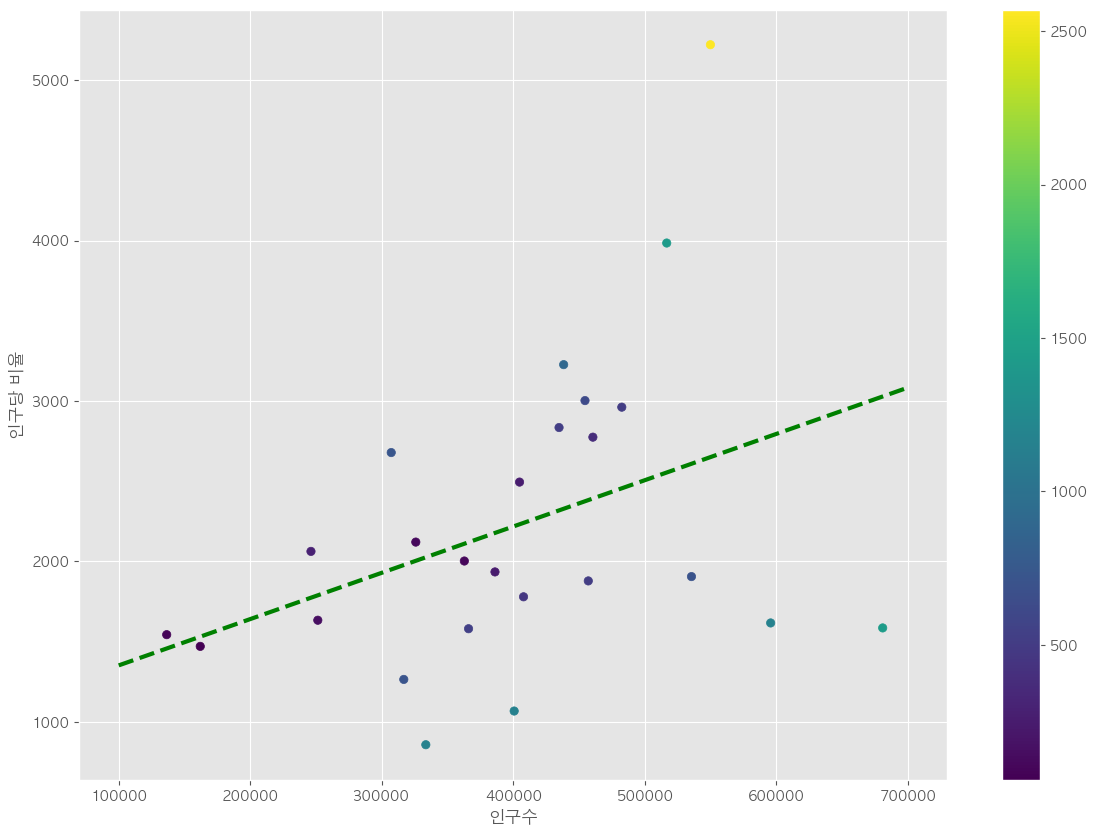

In [174]:
# 그래프에 텍스트와 Color 
plt.figure(figsize=(14,10))
plt.scatter(
    data_result['인구수'],
    data_result['소계'],
    c = data_result['오차']
)
plt.plot(fx, f1(fx), ls='dashed',lw=3,color='g')

# 오차가 가장 큰 10개 구에 이름 붙이기
for n in range(10):
    plt.text(
        df_sort['인구수'][n] * 1.02, # << *1.02는 Point를 가리니까 임의값으로 대충 2% 띄우려고 적은거임
        df_sort['소계'][n] * 0.98,
        df_sort.index[n],
        fontsize=15,

    )

plt.xlabel('인구수')
plt.ylabel('인구당 비율')
plt.colorbar()
# plt.grid()

plt.show()